# Recommendations Systems
## Course Project

The goal of this project is to let you practice in a data scientist daily work by leveraging recommender
systems algorithms you learnt in the course and customize them in order to solve real business
problems.

We will use a dataset based on the <a href='https://grouplens.org/datasets/movielens/1m/'>MovieLens 1M rating dataset</a> after some pre-processing to adapt it to an implicit feedback use case scenario.  
You can download the dataset used by <a href='https://github.com/hexiangnan/neural_collaborative_filtering'>this implementation</a> of the paper Neural Collaborative Filtering or from the NeuralCollaborativeFiltering_implicit notebook in Moodle.
<br>

## Imports:

In [51]:
# General
import os  
import sys
import time
import warnings
import multiprocessing
from icecream import ic

# Data Science
import numpy  as np
import scipy  as sp
import pandas as pd

# Visual
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# Notebook
from IPython.display import display, HTML

# Deep
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import initializers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Dense,Lambda,Activation
from tensorflow.keras.optimizers import Adam,SGD,RMSprop,Adamax
from tensorflow.keras.models import Sequential,Model,load_model,save_model
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Embedding,Input,Dense,Reshape,Flatten,Dropout,Multiply,Concatenate

ModuleNotFoundError: No module named 'tensorflow'

#### Constants:

In [76]:
K = 5 # used to evaluate the model. Top K recommendations are used.
num_factors = 8 # size of embedding size. Can be split to 4 different params potentially.
num_negatives = 4 # how many negative samples per positive sample?
learning_rate = 0.001
batch_size = 256
verbose = 1
epochs = 10

#### Preprocessing:

In [77]:
column_names = ['user_id', 'item_id', 'rating', 'timestamp']

# Read the training file
train = pd.read_csv('./neural_collaborative_filtering/Data/ml-1m.train.rating', sep='\t', names=column_names)

# Read the test file
test_rating = pd.read_csv('./neural_collaborative_filtering/Data/ml-1m.test.rating', sep='\t', names=column_names)


negative_ids = ['(user_id, item_id)']

for i in range(1,100):
    negative_ids.append(f'id-{i}')

test_negative = pd.read_csv('./neural_collaborative_filtering/Data/ml-1m.test.negative', sep='\t', names=negative_ids)


num_users, num_items = train.shape

In [82]:
train.head()
# train.shape()

,user_id,item_id,rating,timestamp
0,0,32,4,978824330
1,0,34,4,978824330
2,0,4,5,978824291
3,0,35,4,978824291
4,0,30,4,978824291


In [66]:
print(str(n_users) + ' users')
print(str(n_items) + ' items')

6040 users
3706 items


## Question 1: Matrix Factorization with custom loss (35 points)

A) Answer:

Given
$$
L=-\frac{1}{N} \sum_{(i, j) \in S}^{N} \alpha_{j}\left(y_{i, j} \log \left(\sigma\left(\mu+p_{i}+o_{j}+\boldsymbol{u}_{i}^{T} v_{j}\right)\right)+\left(1-y_{i, j}\right) \log \left(1-\sigma\left(\mu+p_{i}+o_{j}+\boldsymbol{u}_{i}^{T} v_{j}\right)\right)\right)
$$

Note that:
$$
\log (\sigma (z)) \newline
= \log (\frac{1}{1+e^{-z}}) \newline
= \log(1) - \log(1+e^{-z}) \newline
= -\log(1+e^{-z})
$$
* (Here, we used the fact that $\log(\frac{x}{y}) = \log(x) - \log(y)$)

Similarly:
$$
\log (1 - \sigma (z)) \newline \newline
= \log (1 - \frac{1}{1+e^{-z}}) \newline
= \log (\frac{1+e^{-z} - 1}{1+e^{-z}}) \newline
= \log (\frac{e^{-z}}{1+e^{-z}}) \newline
= \log(e^{-z}) - \log(1+e^{-z}) \newline
= -z - \log(1+e^{-z}) \newline
= -\big( z + \log(1+e^{-z}) \big)
$$


**Denote** $\boldsymbol{z = \mu+p_{i}+o_{j}+{u}_{i}^{T} v_{j}}$ <br>
Now, using $z$ and plugging in the two simplified expressions from above, we obtain:
$$
L=-\frac{1}{N} \sum_{(i, j) \in S}^{N} \alpha_{j}\left(y_{i, j} \log \left(\sigma\left(z\right)\right)+\left(1-y_{i, j}\right) \log \left(1-\sigma\left(z\right)\right)\right) \newline
=-\frac{1}{N} \sum_{(i, j) \in S}^{N} \alpha_{j}\left(-1 \cdot y_{i, j} \log(1+e^{-z}) +\left(1-y_{i, j}\right) 
\left( -(z + \log(1+e^{-z}))\right)\right) \newline
=-\frac{1}{N} \sum_{(i, j) \in S}^{N} \alpha_{j}\left(-1 \cdot y_{i, j} \log(1+e^{-z}) - \left(1-y_{i, j}\right)(z + \log(1+e^{-z})) \right) \newline
= \frac{1}{N} \sum_{(i, j) \in S}^{N} \alpha_{j}\left(y_{i, j} \log(1+e^{-z}) + \left(1-y_{i, j}\right)(z + \log(1+e^{-z})) \right) \newline
$$

After opening up the multiplications, we end up with:
$$
L= \frac{1}{N} \sum_{(i, j) \in S}^{N} \alpha_{j}\left( z - y_{i, j} z + \log(1+e^{-z}) \right)
$$


- Reference: https://math.stackexchange.com/questions/477207/derivative-of-cost-function-for-logistic-regression

All we need now is to compute the partial derivatives of $L$ w.r.t the user and item latent vector weights ($u_i,  v_j$), the global bias ($\mu$), user bias ($p_i$) and item bias ($o_j$) variables for user i and item j.<br>
The update rules are:
$$
u = u - \frac{\partial L}{\partial u} \newline
v = v - \frac{\partial L}{\partial v} \newline
\mu = \mu - \frac{\partial L}{\partial \mu} \newline
p = p - \frac{\partial L}{\partial p} \newline
o = o - \frac{\partial L}{\partial o}
$$

Using the "Chain Rule" - we solve each derivative separately and then plug back in:


- **user latent vector weights ($u_i$):**
$$
\frac{\partial [\alpha_{j} z]}{\partial u_i}
= \frac{\partial [\alpha_{j} (\mu+p_{i}+o_{j}+{u}_{i}^{T} v_{j})]}{\partial u_i} 
= \alpha_{j} v_{j}
$$

$$
\frac{\partial [-\alpha_{j}  y_{i, j} z]}{\partial u_i}
= \frac{\partial [- \alpha_{j} y_{i, j}(\mu+p_{i}+o_{j}+{u}_{i}^{T} v_{j})]} {\partial u_i} 
= -\alpha_{j} y_{i, j} v_{j}
$$


$$
\frac{\partial [\alpha_{j}  \log(1+e^{-z})]}{\partial u_i}
= \frac{\alpha_j e^{-z} \frac{\partial z}{\partial u_i}} {1 + e^{-z}}
= - \frac{\alpha_{j} e^{-z} v_{j}}{1 + e^{-z}}
$$

* (Last transition, log derivative, follows from [here](https://www.symbolab.com/solver/step-by-step/%5Cleft(log_%7Be%7D%5Cleft(1%2Be%5E%7B-2x%7D%5Cright)%5Cright)%5E%7B'%7D))

Hence,
$$
\frac{\partial L}{\partial u_i}
= \frac{1}{N} \sum_{(i, j) \in S}^{N} \big( \alpha_{j} v_{j} - \alpha_{j} y_{i, j} v_{j} - \frac{\alpha_{j} e^{-z} v_{j}}{1 + e^{-z}} \big) 
= \frac{1}{N} \sum_{(i, j) \in S}^{N} \alpha_{j} v_{j} \big( 1 - y_{i, j} - \frac{e^{-z}}{1 + e^{-z}} \big) 
$$


- **item latent vector weights ($v_j$)** is very similar, since both terms are multiplied with each other:
$$
\frac{\partial L}{\partial v_j}
= \frac{1}{N} \sum_{(i, j) \in S}^{N} \big( \alpha_{j} {u}_{i}^{T} - \alpha_{j} y_{i, j} {u}_{i}^{T} - \frac{\alpha_{j} e^{-z} {u}_{i}^{T}}{1 + e^{-z}} \big) 
= \frac{1}{N} \sum_{(i, j) \in S}^{N} \alpha_{j} {u}_{i}^{T} \big( 1 - y_{i, j} - \frac{e^{-z}}{1 + e^{-z}} \big) 
$$


- **the global bias, $\mu$:**
$$
\frac{\partial [\alpha_{j} z]}{\partial \mu}
= \frac{\partial [\alpha_{j} (\mu+p_{i}+o_{j}+{u}_{i}^{T} v_{j})]}{\partial \mu} 
= \alpha_{j}
$$

$$
\frac{\partial [-\alpha_{j}  y_{i, j} z]}{\partial \mu}
= \frac{\partial [- \alpha_{j} y_{i, j}(\mu+p_{i}+o_{j}+{u}_{i}^{T} v_{j})]} {\partial \mu} 
= -\alpha_{j} y_{i, j}
$$

$$
\frac{\partial [\alpha_{j}  \log(1+e^{-z})]}{\partial \mu}
= \frac{\partial [\alpha_{j} \log(1 + e^{\mu+p_{i}+o_{j}+{u}_{i}^{T} v_{j}})]} {\partial \mu} 
= \frac{\alpha_j e^{-z} \frac{\partial z}{\partial u_i}} {1 + e^{-z}}
= - \frac{\alpha_{j} e^{-z}}{1 + e^{-z}}
$$

Hence,
$$
\frac{\partial L}{\partial \mu}
= \frac{1}{N} \sum_{(i, j) \in S}^{N} \big( \alpha_{j} - \alpha_{j} y_{i, j} - \frac{\alpha_{j} e^{-z}}{1 + e^{-z}} \big) 
= \frac{1}{N} \sum_{(i, j) \in S}^{N} \alpha_{j} \big( 1 - y_{i, j} - \frac{e^{-z}}{1 + e^{-z}} \big) 
$$


- **user bias $p_i$** follows the same calculation as $\mu$ since it's added as a standalone addition:
$$
\frac{\partial L}{\partial p_i}
= \frac{\partial L}{\partial \mu}
= \frac{1}{N} \sum_{(i, j) \in S}^{N} \alpha_{j} \big( 1 - y_{i, j} - \frac{e^{-z}}{1 + e^{-z}} \big) 
$$


- **item bias $o_j$** follows the same calculation as $\mu$ since it's added as a standalone addition:
$$
\frac{\partial L}{\partial o_j}
= \frac{\partial L}{\partial \mu}
= \frac{1}{N} \sum_{(i, j) \in S}^{N} \alpha_{j} \big( 1 - y_{i, j} - \frac{e^{-z}}{1 + e^{-z}} \big) 
$$

B) Answer:

Given the prices of the different items from the catalog, we can set the weights for each training instance based on the **item price divided by the maximal price** we have.
Meaning, we're giving each weight its relative "significance".

This is very intuitive and straightforward - The more expensive an item is, the larger weight it's given, where weights' values range from 0 to 1.

***
## Question 2: Neural Collaborative Filtering

##### A) Use the item_price.csv file to get the prices of each item. Explore the price distribution of items.
Answer:

In [67]:
item_price = pd.read_csv('./item_price.csv')
item_price.set_index('item')

,price
item,
0,4
1,1
2,1
3,2
4,2
...,...
3701,25
3702,4
3703,1


In [68]:
number_of_items = item_price.shape[0]
prices = item_price['price']
min_price = prices.min()
max_price = prices.max()

([<matplotlib.axis.XTick at 0x2654f2072b0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

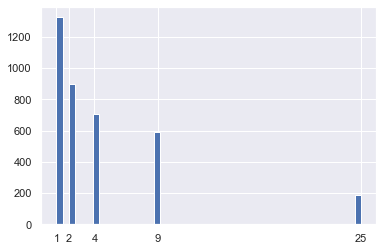

In [69]:
plt.hist(item_price.price, align='mid', bins=50)
plt.xticks(item_price.price.unique())

In [70]:
item_price.groupby('price')['item'].nunique()

price
1     1326
2      896
4      709
9      589
25     186
Name: item, dtype: int64

In [71]:
item_price.describe()

,item,price
count,3706.000000,3706.000000
mean,1852.500000,4.291689
std,1069.974377,5.496992
min,0.000000,1.000000
25%,926.250000,1.000000
50%,1852.500000,2.000000
75%,2778.750000,4.000000
max,3705.000000,25.000000


There are 3706 items with prices distributed from [1, 2, 4, 9, 25].<br>
From the histogram and the data we see that most of the items are priced 2 and lower - ((1: 1326), (2: 896), (4: 709), (9: 589), (25: 186))<br>
It doesn't look like we can deduce a behaviour of a specific distribution (like normal/uniform etc.), especially since we don't have enough data other than ID numbers and prices...<br>

##### B) To evaluate the performance of the price sensitive model we add another metric Revenue@K which measures the overall revenue from the top 5 recommended hits.
Answer:

In [88]:
def get_revenue_k(rank_list, gt_item):
    for item in rank_list:
        if item == gt_item:
            return _item_price[_item_price.item == item].price
    return 0

##### C) Suggest a metric of your own which will incorporate both the ranking of the recommended items as well as its price. Explain why this metric is suitable and demonstrate it as part of the evaluation in point e below.
Answer:

In bullet B we got the top K hits and calculated the revenue for them. What I am suggesting is to make it take into considuration the NDCG. the motivation here is that the model that will win will produce the most profit calculated from the higest rated items he manage to get a hit. and got the most gain from the fact that it predicted more top rated items in the right place then it's compatitors.

In [89]:
# revenue_k.mean <-- normalized price 

# revenue_k.mean * ndcg_revenue_k.mean (B)
# revenue_k.mean * ndcg.mean (A)
# revenue_k.mean + ndcg.mean
# revenue_k.mean + ndcg_revenue_k.mean

##### D) Select one of the models presented in the Neural Collaborative Filtering paper and incorporate the movie price to the loss function as part of training
Answer:

In [92]:
def get_GMF_model(num_users, num_items, latent_dim, regs=None, activation='sigmoid'):
    '''Generalized Matrix Factorization'''

    if not regs:
        regs = [[0,0]]
    
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')

    MF_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim, name = 'user_embedding',
                                   embeddings_regularizer = l2(regs[0][0]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01)) #init = init_normal,
    MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim, name = 'item_embedding',
                                   embeddings_regularizer = l2(regs[0][1]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01))  #init = init_normal, 
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MF_Embedding_User(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))
    
    # Element-wise product of user and item embeddings 
    predict_vector = Multiply()([user_latent, item_latent]) #merge([user_latent, item_latent], mode = 'mul')
    
    # Final prediction layer
    prediction = Dense(1, activation=activation, kernel_initializer='lecun_uniform', name = 'prediction')(predict_vector)
    model = Model(inputs=[user_input, item_input], outputs=prediction)
    
    return model

In [ ]:
def my_loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=-1)  # Note the `axis=-1`

In [91]:
# TEST
T = [11, 12, 5, 2]
T2 = [10, 11, 4, 1]
diff = np.subtract(T,T2)

print(diff)
diff * item_price['price'].values[:len(result)]

[1 1 1 1]


array([4, 1, 1, 2], dtype=int64)

In [93]:
# Build model
def build_model():
    gmf_model = get_GMF_model(num_users, num_items, num_factors, regs = [[0,0]])
    gmf_model.compile(optimizer=Adam(lr=learning_rate), loss=my_loss_fn)
   
    return gmf_model

##### E) Compare the results of the original model and the one with the customized loss across the four metrics: (20 points)
- MRR@5
- NDCG@5
- Revenue@5 
- your custom metric

In [ ]:
'''
Keras Implementation of Generalized Matrix Factorization (GMF) recommender model in:
He Xiangnan et al. Neural Collaborative Filtering. In WWW 2017.  
'''
import theano.tensor as T
import keras
from keras import backend as K
from keras import initializations
from keras.models import Sequential, Model, load_model, save_model
from keras.layers.core import Dense, Lambda, Activation
from keras.layers import Embedding, Input, Dense, merge, Reshape, Merge, Flatten
from keras.optimizers import Adagrad, Adam, SGD, RMSprop
from keras.regularizers import l2
from Dataset import Dataset
from evaluate import evaluate_model
from time import time
import multiprocessing as mp
import sys
import math
import argparse

#################### Arguments ####################
def parse_args():
    parser = argparse.ArgumentParser(description="Run GMF.")
    parser.add_argument('--path', nargs='?', default='Data/',
                        help='Input data path.')
    parser.add_argument('--dataset', nargs='?', default='ml-1m',
                        help='Choose a dataset.')
    parser.add_argument('--epochs', type=int, default=100,
                        help='Number of epochs.')
    parser.add_argument('--batch_size', type=int, default=256,
                        help='Batch size.')
    parser.add_argument('--num_factors', type=int, default=8,
                        help='Embedding size.')
    parser.add_argument('--regs', nargs='?', default='[0,0]',
                        help="Regularization for user and item embeddings.")
    parser.add_argument('--num_neg', type=int, default=4,
                        help='Number of negative instances to pair with a positive instance.')
    parser.add_argument('--lr', type=float, default=0.001,
                        help='Learning rate.')
    parser.add_argument('--learner', nargs='?', default='adam',
                        help='Specify an optimizer: adagrad, adam, rmsprop, sgd')
    parser.add_argument('--verbose', type=int, default=1,
                        help='Show performance per X iterations')
    parser.add_argument('--out', type=int, default=1,
                        help='Whether to save the trained model.')
    return parser.parse_args()


def init_normal(shape, name=None):
    return initializations.normal(shape, scale=0.01, name=name)


def get_model(num_users, num_items, latent_dim, regs=[0,0]):
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')

    MF_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim, name = 'user_embedding',
                                  init = init_normal, W_regularizer = l2(regs[0]), input_length=1)
    MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim, name = 'item_embedding',
                                  init = init_normal, W_regularizer = l2(regs[1]), input_length=1)   
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MF_Embedding_User(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))
    
    # Element-wise product of user and item embeddings 
    predict_vector = merge([user_latent, item_latent], mode = 'mul')
    
    # Final prediction layer
    #prediction = Lambda(lambda x: K.sigmoid(K.sum(x)), output_shape=(1,))(predict_vector)
    prediction = Dense(1, activation='sigmoid', init='lecun_uniform', name = 'prediction')(predict_vector)
    
    model = Model(input=[user_input, item_input], 
                output=prediction)

    return model


def get_train_instances(train, num_negatives):
    user_input, item_input, labels = [],[],[]
    num_users = train.shape[0]
    for (u, i) in train.keys():
        # positive instance
        user_input.append(u)
        item_input.append(i)
        labels.append(1)
        # negative instances
        for t in xrange(num_negatives):
            j = np.random.randint(num_items)
            while train.has_key((u, j)):
                j = np.random.randint(num_items)
            user_input.append(u)
            item_input.append(j)
            labels.append(0)
    return user_input, item_input, labels


if __name__ == '__main__':
    args = parse_args()
    num_factors = args.num_factors
    regs = eval(args.regs)
    num_negatives = args.num_neg
    learner = args.learner
    learning_rate = args.lr
    epochs = args.epochs
    batch_size = args.batch_size
    verbose = args.verbose
    
    topK = 10
    evaluation_threads = 1 #mp.cpu_count()
    print("GMF arguments: %s" %(args))
    model_out_file = 'Pretrain/%s_GMF_%d_%d.h5' %(args.dataset, num_factors, time())
    
    # Loading data
    t1 = time()
    dataset = Dataset(args.path + args.dataset)
    train, testRatings, testNegatives = dataset.trainMatrix, dataset.testRatings, dataset.testNegatives
    num_users, num_items = train.shape
    print("Load data done [%.1f s]. #user=%d, #item=%d, #train=%d, #test=%d" 
          %(time()-t1, num_users, num_items, train.nnz, len(testRatings)))
    
    # Build model
    model = get_model(num_users, num_items, num_factors, regs)
    if learner.lower() == "adagrad": 
        model.compile(optimizer=Adagrad(lr=learning_rate), loss='binary_crossentropy')
    elif learner.lower() == "rmsprop":
        model.compile(optimizer=RMSprop(lr=learning_rate), loss='binary_crossentropy')
    elif learner.lower() == "adam":
        model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy')
    else:
        model.compile(optimizer=SGD(lr=learning_rate), loss='binary_crossentropy')
    #print(model.summary())
    
    # Init performance
    t1 = time()
    (hits, ndcgs) = evaluate_model(model, testRatings, testNegatives, topK, evaluation_threads)
    hr, ndcg = np.array(hits).mean(), np.array(ndcgs).mean()
    #mf_embedding_norm = np.linalg.norm(model.get_layer('user_embedding').get_weights())+np.linalg.norm(model.get_layer('item_embedding').get_weights())
    #p_norm = np.linalg.norm(model.get_layer('prediction').get_weights()[0])
    print('Init: HR = %.4f, NDCG = %.4f\t [%.1f s]' % (hr, ndcg, time()-t1))
    
    # Train model
    best_hr, best_ndcg, best_iter = hr, ndcg, -1
    for epoch in xrange(epochs):
        t1 = time()
        # Generate training instances
        user_input, item_input, labels = get_train_instances(train, num_negatives)
        
        # Training
        hist = model.fit([np.array(user_input), np.array(item_input)], #input
                         np.array(labels), # labels 
                         batch_size=batch_size, nb_epoch=1, verbose=0, shuffle=True)
        t2 = time()
        
        # Evaluation
        if epoch %verbose == 0:
            (hits, ndcgs) = evaluate_model(model, testRatings, testNegatives, topK, evaluation_threads)
            hr, ndcg, loss = np.array(hits).mean(), np.array(ndcgs).mean(), hist.history['loss'][0]
            print('Iteration %d [%.1f s]: HR = %.4f, NDCG = %.4f, loss = %.4f [%.1f s]' 
                  % (epoch,  t2-t1, hr, ndcg, loss, time()-t2))
            if hr > best_hr:
                best_hr, best_ndcg, best_iter = hr, ndcg, epoch
                if args.out > 0:
                    model.save_weights(model_out_file, overwrite=True)

    print("End. Best Iteration %d:  HR = %.4f, NDCG = %.4f. " %(best_iter, best_hr, best_ndcg))
    if args.out > 0:
        print("The best GMF model is saved to %s" %(model_out_file))

In [ ]:
import math
import heapq # for retrieval topK
import multiprocessing
from time import time


def evaluate_model(model, test_ratings, test_negatives, K):
    """
    Evaluate the performance (MRR, NDCG) of top-K recommendation
    Return: score of each test rating.
    """
    mrrs, ndcgs = zip(*[eval_one_rating(model, test_ratings, test_negatives, idx, K) for idx in range(len(test_ratings))])
    return np.array(mrrs).mean(), np.array(ndcgs).mean()


def eval_one_rating(model, test_ratings, test_negatives, idx, K):
    u = test_ratings.iloc[idx].user_id
    gtItem = test_ratings.iloc[idx].item_id
    items = test_negatives[test_negatives['(user_id, item_id)'] == f'({u},{gtItem})'].to_numpy()[0]
    items = items[1:len(items)].astype('int32')
    items = np.append(items, gtItem)
    users = np.full(len(items), u, dtype = 'int32')
    # Get prediction scores
    map_item_score = {}
    predictions = model.predict([users, np.array(items)], 
                                 batch_size=100, verbose=0)
    
    for i in range(len(items)):
        item = items[i]
        map_item_score[item] = predictions[i]
    
    items = items[:len(items)-1]
    
    # Evaluate top rank list
    ranklist = heapq.nlargest(K, map_item_score, key=map_item_score.get)
    mrr = getMRR(ranklist, gtItem)
    ndcg = getNDCG(ranklist, gtItem)
    
    return mrr, ndcg


def getMRR(ranklist, gtItem):
    for i in range(len(ranklist)):
        item = ranklist[i]
        
        if item == gtItem:
            return 1/(i+1)
    return 0


def getNDCG(ranklist, gtItem):
    for i in range(len(ranklist)):
        item = ranklist[i]
        
        if item == gtItem:
            return math.log(2) / math.log(i+2)
    return 0

In [ ]:
def initPerformance(name, model):
    t1 = time()
    mrr, ndcg = evaluate_model(model, test_rating, test_negative, K)
    print(f'{name}, k: {K}, Rev@K = {}, MRR = {mrr:.4f}, NDCG = {ndcg:.4f}\t t1 = [{(time()-t1)/60}s]')
    return mrr, ndcg

In [ ]:
gmf_model = build_model()
mrr_GMF, ndcg_GMF = initPerformance('GMF', gmf_model)

In [94]:
def get_train_instances(train, num_negatives):
    user_input, item_input, labels = [0]*((num_negatives + 1)*len(train)),[0]*((num_negatives + 1)*len(train)),[1]
    num_users = train.shape[0]
    all_items = training.item_id.unique().argsort()
    
    negatives = [0]*num_negatives
    labels.extend(negatives)
    total_labels = []
    list(map(lambda x: total_labels.extend(labels), range(len(train))))
#     return
    percent_1 = int(len(train)/100)
    ic(percent_1)
    
    items_the_user_didnt_rank = None
    prev_user = -1
    chosen_item_per_user = []
    
    for idx_i in range(len(train)):
        curr_index = idx_i * (num_negatives + 1)
        if idx_i != 0 and idx_i % percent_1 == 0:
            print(f'{int(idx_i/percent_1)}%')
        u = train.iloc[idx_i].user_id
        i = train.iloc[idx_i].item_id

        user_input[curr_index:curr_index + (num_negatives + 1)] = [u]*(num_negatives + 1)

        item_input[curr_index] = i
        
        if u != prev_user:
            items = training[training['user_id'] == u].item_id.to_numpy().argsort()
            items_the_user_didnt_rank = all_items[~np.in1d(all_items,items)]
            prev_user = u
#             chosen_item_per_user = []

#         items_the_user_didnt_rank = items_the_user_didnt_rank[~np.in1d(items_the_user_didnt_rank,chosen_item_per_user)]
        sample_items = items_the_user_didnt_rank[np.random.choice(len(items_the_user_didnt_rank), size=num_negatives, replace=False)]
        item_input[curr_index+1:curr_index + (num_negatives + 1)] = sample_items
#         chosen_item_per_user.extend(sample_items)

    return user_input, item_input, total_labels



# THE ORIGINAL CODE:

# def get_train_instances(train, num_negatives):
#     user_input, item_input, labels = [],[],[]
#     num_users = train.shape[0]
#     for (u, i) in train.keys():
#         # positive instance
#         user_input.append(u)
#         item_input.append(i)
#         labels.append(1)
#         # negative instances
#         for t in xrange(num_negatives):
#             j = np.random.randint(num_items)
#             while train.has_key((u, j)):
#                 j = np.random.randint(num_items)
#             user_input.append(u)
#             item_input.append(j)
#             labels.append(0)
#     return user_input, item_input, labels

In [ ]:
# Train model
models_and_input = [('GMF', gmf_model, mrr_GMF, ndcg_GMF)]

for model_and_input in models_and_input:
    model_name, model, mrr, ndcg = model_and_input
    best_mrr, best_ndcg, best_iter = mrr, ndcg, -1
    print(f"Running on Model: {model_name}")

    for epoch in range(epochs):
        t1 = time()
        
        # Generate training instances
        user_input, item_input, labels = get_train_instances(train, num_negatives)

        # Training
        print('Training - start')
        hist = model.fit([np.array(user_input), np.array(item_input)], #input
                         np.array(labels), # labels 
                         batch_size=batch_size, epochs=1, verbose=0, shuffle=True)
        print('Training - end')
        
        t2 = time()

        # Evaluation
        print('Evaluation - start') 

        if epoch % verbose == 0:
            mrr, ndcg = evaluate_model(model, test_rating, test_negative)
            loss = hist.history['loss'][0]
            print(f'Iteration {epoch} [{t2-t1:.1f} s]: MRR = {mrr:.4f}, NDCG = {ndcg:.4f}, loss = {loss:.4f} [{time()-t2:.1f} s]')

            if mrr > best_mrr:
                best_mrr, best_ndcg, best_iter = mrr, ndcg, epoch
        print(f"---------End Epoch: {epoch}---------")

    print(f"End. Best Iteration {best_iter}:  MRR = {best_mrr:.4f}, NDCG = {best_ndcg:.4f}. ")

<br>
- Compare between different heuristics of item price to weights mapping. 

<br>
- Present the comparison results, discuss the results and the trade-offs and optimize

<br>
- Compare between different heuristics of item price to weights mapping. 

<br>
- Verify and present that the learning is ‘healthy’ (no overfitting, no under-fitting and that the results make sense)

***
## Question 3: Loss function
Cold start or users\items with a small number of interactions is a very common scenario in real world. In this question you will plan how you can leverage content based features to handle the cold start scenario.


A) Answer:

B) Answer:

C) Answer:

[1, 2, 3, 4]